In [1]:
import numpy as np
import pandas as pd
from spoc import generate_spoc_model as gen_model
from spoc import spoc 
import matplotlib.pyplot as plt
import example_utils

from tqdm import tqdm_notebook
from IPython.display import clear_output, display

%matplotlib inline

Firstly, we generate simple synthetic example with 1000 nodes in graph and with 2 clusters. We assume that there are 10 pure nodes (check our paper __[article](https://arxiv.org/abs/1707.01350)__). Also for certainty we put pure nodes in the first 10 nodes.

In [2]:
n_nodes = 1000
n_clusters = 2
pnn = 10
pure_inds = list(range(10))

Now we create $\Theta$ matrix from __[Dirichlet distribution](https://en.wikipedia.org/wiki/Dirichlet_distribution)__ and set $B$ matrix to $diag(0.7, 0.3)$. In this way

$$ P = \Theta B \Theta^T. $$

Further we assume that $A \sim Bernoulli(P)$ where A is an adjacency matrix of a graph. Now we make an eigenvalue decomposition $A = U L U^T$ and plot scatter plot of 2 first eigenvectors corresponding to the 2 biggest eigenvalues.

When we run $SPA$ algorithm it selects some nodes as a simplex vertices.

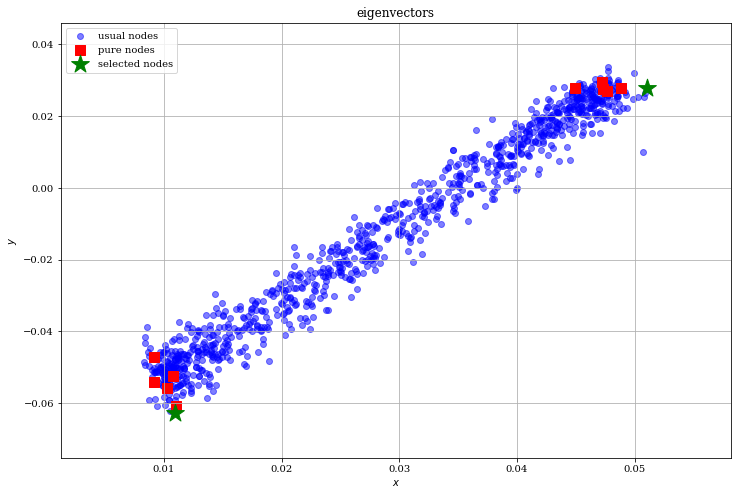

In [3]:
Theta = gen_model.generate_theta(n_nodes,
                                n_clusters,
                                pnn,
                                pure_nodes_indices=pure_inds,
                                seed=42)
### Fix B matrix
B = np.array([[0.7, 0], [0, 0.3]])
P = Theta.dot(B).dot(Theta.T)

### Finally, create adjacency matrix
### from P matrix via Bernoulli distribution
A = gen_model.P_to_A(P)

example_utils.plot_spectrum(A, n_clusters,
                            pure_inds=pure_inds,
                            draw_selected=True)

Increase number of communities to 3 and plot 2 first eigenvectors.

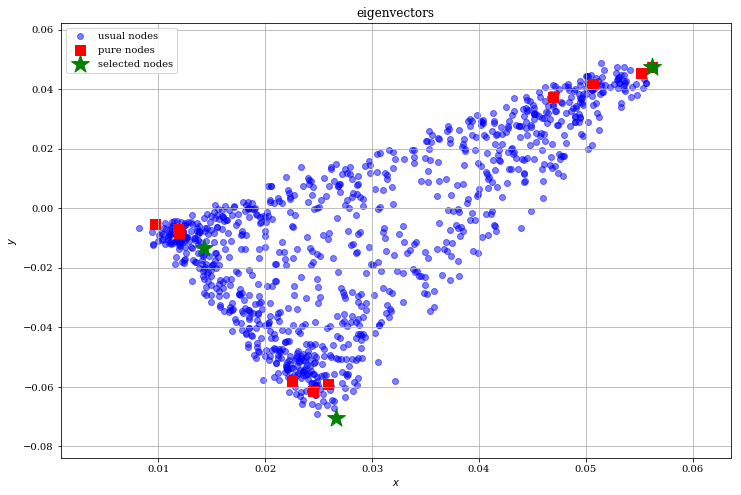

In [4]:
n_clusters = 3
Theta = gen_model.generate_theta(n_nodes,
                                n_clusters,
                                pnn,
                                pure_nodes_indices = 
                                pure_inds,
                                seed=42)

B = np.array([[0.7, 0, 0], [0, 0.5, 0], [0, 0, 0.3]])
P = Theta.dot(B).dot(Theta.T)
A = gen_model.P_to_A(P)
example_utils.plot_spectrum(A, n_clusters,
                            pure_inds=pure_inds,
                            draw_selected=True)

We can find an error of $\Theta$ and $B$ matrices estimation in this synthetic example because we know a priori value of $\Theta$ and $B$.

In [5]:
spoc_obj = spoc.SPOC()
Theta_exp, B_exp = spoc_obj.fit(A, n_clusters)

### check error of recovering
error = gen_model.find_theta_error(Theta, Theta_exp)
print('relative error in Theta matrix recovering {}'.format(error))

error = gen_model.find_b_error(B, B_exp)
print('relative error in B matrix recovering {}'.format(error))

relative error in Theta matrix recovering 0.133266577599
relative error in B matrix recovering 0.249255375005


Let consider bootstrap version of $SPOC$ method. When $SPA$ algorithm is detecting the node with highest value of $L_2$ norm we can bootstrap coordinates of this node and replace the node coordinates by the average of nodes which are inside of a confidence interval.

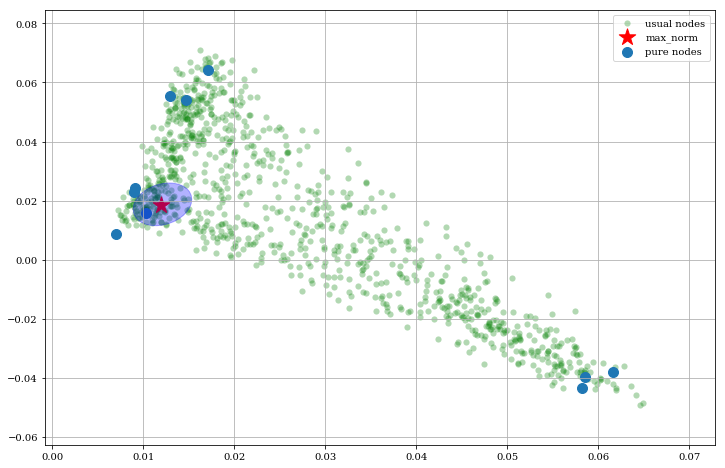

In [6]:
A, _, _ = gen_model.generate_a(n_nodes, n_clusters,
                               pnn, seed=13,
                               pure_nodes_indices=pure_inds)

spoc_obj = spoc.SPOC(use_bootstrap=True,
                    n_repetitions=100,
                    return_bootstrap_matrix=True)

U, L = spoc.SPOC._get_U_L(A, n_clusters)
Theta, B, bootstrap_matrix = spoc_obj.fit(A, n_clusters)

### Find the node with the largest norm
### in eigenvectors coordinates
max_index = np.argsort(-np.linalg.norm(U, axis=1))[0]

plt.figure(figsize=(12, 8))
plt.scatter(U[:, 0], U[:, 1], label="usual nodes",
            linewidths=0.1, c="g", alpha=0.3)

plt.scatter(U[max_index, 0], U[max_index, 1], label="max_norm",
            marker='*', s=300, c="r", alpha=1)

example_utils.plot_point_cov(bootstrap_matrix[:,max_index, :2],
                             nstd=2, alpha=0.3, color="b")

plt.scatter(U[pure_inds, 0], U[pure_inds, 1],
            label='pure nodes', marker='o', s=100)

plt.grid()
plt.legend()

In [7]:
### Check the result of
### bootstrap algorithm

n_clusters = 2
A, Theta, B = gen_model.generate_a(n_nodes,
                                   n_clusters,
                                   pnn, seed=1)

spoc_obj = spoc.SPOC(use_bootstrap=True,
                     n_repetitions=100)

Theta_exp, B_exp = spoc_obj.fit(A, n_clusters)

### check error of recovering
error = gen_model.find_theta_error(Theta, Theta_exp)
print('relative error in Theta matrix recovering {}'.format(error))

error = gen_model.find_b_error(B, B_exp)
print('relative error in B matrix recovering {}'.format(error))

relative error in Theta matrix recovering 0.054569085255
relative error in B matrix recovering 0.0234948921007
